# Detectron with custom Dataset

## Preparing the data is very crutial step

In [ ]:
# !pip install pyyaml==5.1
# !pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

In [ ]:
!pip install pyyaml==5.1
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
import torch
print(torch.__version__)
print(torch.cuda.is_available())
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4 MB 16 kB/s 
  Using cached https://download.pytorch.org/whl/cu101/torchvision-0.8.2%2Bcu101-cp37-cp37m-linux_x86_64.whl (12.8 MB)
  Using cached torchaudio-0.7.2-cp37-cp37m-manylinux1_x86_64.whl (7.6 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchvision-0.9.0+cu101
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.11.0+cu113
    Uninstalling torchaudio-0.11.0+cu113:
      Successfully uninstalled torchaudio-0.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source 

In [ ]:
import detectron2
print(detectron2.__version__)

0.5


In [ ]:
# !pip install pyyaml==5.1
# !pip install torch==1.8.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

In [ ]:
import torch
import torchvision
import cv2

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}

        filename = os.path.join(directory, img_anns["imagePath"])

        record["file_name"] = filename
        record["height"] = 224
        record["width"] = 224

        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x coord
            py = [a[1] for a in anno['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [ ]:
classes = ['benign', 'malignant']

data_path = '/content/drive/MyDrive/skin_data/'

for d in ["train", "test"]:
    DatasetCatalog.register(
        "category_" + d,
        lambda d=d: get_data_dicts(data_path+d, classes)
    )
    MetadataCatalog.get("category_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("category_train")

# Training the Detectron2 Instance Segmentation Model

In [ ]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("category_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

# load the parameters of instance segmentation of pretrained model

In [ ]:
from detectron2.structures import BoxMode
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

[05/07 06:34:05 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:02, 64.5MB/s]
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 25

# Train the NN

In [ ]:
trainer.train()

[05/07 06:34:58 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/masks.py:363: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/usr/local/lib/python3.7/dist-packages/detectron2/structures/masks.py:363: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/usr/local/lib/python3.7/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/

[05/07 06:35:06 d2.utils.events]:  eta: 0:06:14  iter: 19  total_loss: 2.019  loss_cls: 1.187  loss_box_reg: 0.118  loss_mask: 0.6917  loss_rpn_cls: 0.007423  loss_rpn_loc: 0.01125  time: 0.3673  data_time: 0.0194  lr: 4.9953e-06  max_mem: 2034M
[05/07 06:35:13 d2.utils.events]:  eta: 0:05:54  iter: 39  total_loss: 1.797  loss_cls: 0.9342  loss_box_reg: 0.1368  loss_mask: 0.6863  loss_rpn_cls: 0.00597  loss_rpn_loc: 0.01098  time: 0.3652  data_time: 0.0068  lr: 9.9902e-06  max_mem: 2034M
[05/07 06:35:21 d2.utils.events]:  eta: 0:05:48  iter: 59  total_loss: 1.402  loss_cls: 0.5704  loss_box_reg: 0.1316  loss_mask: 0.6811  loss_rpn_cls: 0.007875  loss_rpn_loc: 0.009801  time: 0.3667  data_time: 0.0069  lr: 1.4985e-05  max_mem: 2034M
[05/07 06:35:28 d2.utils.events]:  eta: 0:05:37  iter: 79  total_loss: 1.112  loss_cls: 0.3144  loss_box_reg: 0.1138  loss_mask: 0.6654  loss_rpn_cls: 0.0149  loss_rpn_loc: 0.01184  time: 0.3652  data_time: 0.0056  lr: 1.998e-05  max_mem: 2034M
[05/07 06:35:

# Inference using the trained model

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("skin_test", )
predictor = DefaultPredictor(cfg)

In [ ]:
test_dataset_dicts = get_data_dicts(data_path+'test', classes)

In [ ]:
len(test_dataset_dicts)

8

In [ ]:
for i in test_dataset_dicts:
  print(i)

{'file_name': '/content/drive/MyDrive/skin_data/test/benign_1.jpg', 'height': 224, 'width': 224, 'annotations': [{'bbox': [80.40677966101694, 97.96610169491525, 136.6779661016949, 134.91525423728814], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[80.40677966101694, 117.62711864406779, 84.47457627118644, 115.25423728813558, 82.44067796610167, 106.77966101694915, 90.91525423728814, 105.76271186440677, 93.96610169491524, 107.11864406779661, 102.77966101694915, 105.76271186440677, 105.83050847457625, 97.96610169491525, 111.25423728813558, 103.05084745762711, 125.15254237288136, 101.69491525423729, 128.54237288135593, 103.05084745762711, 128.54237288135593, 108.47457627118644, 132.27118644067795, 110.16949152542372, 136.6779661016949, 117.62711864406779, 127.18644067796609, 122.3728813559322, 109.5593220338983, 122.71186440677965, 109.5593220338983, 129.83050847457628, 106.84745762711864, 134.91525423728814, 97.69491525423729, 133.22033898305085, 97.69491525423729, 125.4237288135593

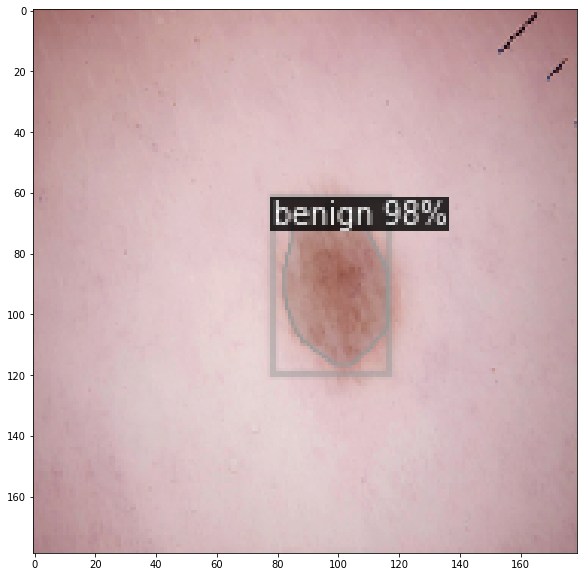

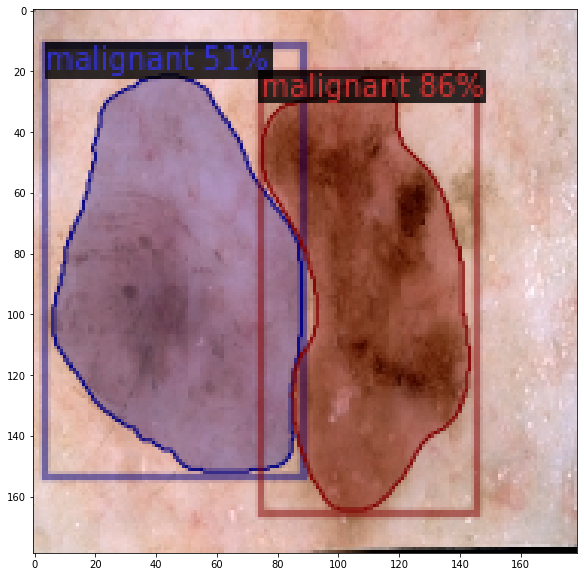

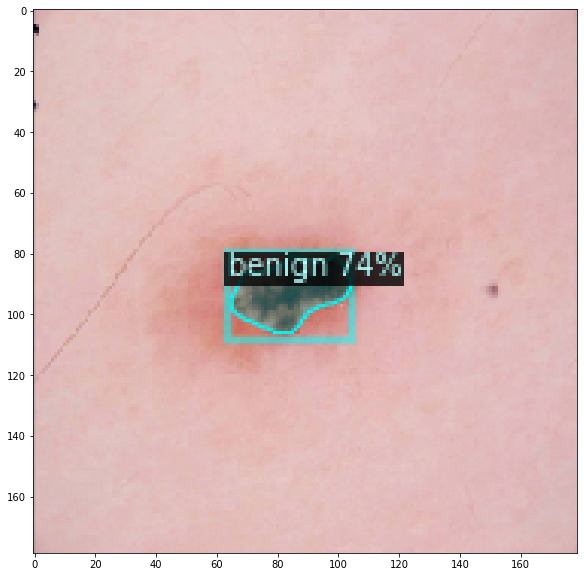

In [ ]:
import matplotlib.pyplot as plt
for d in random.sample(test_dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=microcontroller_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

# END ----------------------------------------------------------------------------------